In [13]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            pass
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [15]:
def get_labels(array,threshold):
    lst = []
    for i in range(len(array)):
        if array[i] >= threshold:
            lst.append(1)
        else:
            lst.append(0)
    return lst

In [16]:
def pred_labels(array,y_true = None, set_best_threshold=True,threshold=0.1, jumps = 1000):
    if set_best_threshold:
        print("finding best threshold..")
        max_f1 = 0
        best_threshold = 0
        for i in [e/jumps for e in list(range(0,jumps))]:
            labels = get_labels(array,i)
            f1 = f1_score(y_true,labels)
            if f1>max_f1:
                max_f1 = f1
                best_threshold = i
        print("best threshold: "+str(best_threshold))
        print("f1-score at this threshold: "+str(max_f1))
        return get_labels(array,best_threshold)
    else:
        return get_labels(array,threshold)

### Read Data & Feature Dictionary

In [337]:
main = pd.read_csv("./data/model_data_jan.csv")

In [338]:
dtypes_df = pd.read_csv("feature_dictionary.csv")
cat_features = dtypes_df[dtypes_df.dtype2=="cat"].feature.tolist()
cont_features =  dtypes_df[dtypes_df.dtype2=="cont"].feature.tolist()

### Preprocess Data

#### > Fill NAs

In [412]:
def fill_nas(main):
    for col in dtypes_df.feature:
        try:
            if col in cat_features:
                main[col].fillna("Missing",inplace=True)
            else:
                main[col] = main[col].apply(lambda x: x if (x!=None) and (x!=np.nan) and (np.isnan(x)!=True) else main[col].mean())
        except:
            print(col+" cannot be found (or something else happened.)")
    return main

In [411]:
def find_nas(main):
    for col in dtypes_df.feature:
        if main[(main[col].isna())|(main[col].str.find('Missing')!=-1)].shape[0]!=0:
            print(col+" has Nulls in it.")

In [341]:
main = fill_nas(main)

#### > Transform Categorical Features

In [342]:
def transform_cats(main):
    for col in cat_features:
        if col.find("_transformed1")==-1 and col.find("_clustered")==-1:
            try:
                le = LabelEncoder()
                le.fit(main[col].tolist())
                main[col+"_transformed"] = le.transform(main[col].tolist())
            except e:
                print("Error: "+e)
        else:
            print(col + " is already transformed.")
    return main

In [343]:
main = transform_cats(main)

ultimo_ivr_departamento_clustered_2 is already transformed.
ultimo_ivr_departamento_clustered_5 is already transformed.
ultima_categoria_open_question_clustered_2 is already transformed.
ultima_categoria_open_question_clustered_5 is already transformed.
ultima_categoria_open_question_clustered_8 is already transformed.
ultima_categoria_open_question_clustered_11 is already transformed.
ultima_subcategoria_open_question_clustered_2 is already transformed.
ultima_subcategoria_open_question_clustered_5 is already transformed.
ultima_subcategoria_open_question_clustered_8 is already transformed.
ultima_subcategoria_open_question_clustered_11 is already transformed.
grupo_acd_clustered_2 is already transformed.
grupo_acd_clustered_5 is already transformed.
grupo_acd_clustered_8 is already transformed.
grupo_acd_clustered_11 is already transformed.
tariff_ds_clustered_2 is already transformed.
tariff_ds_clustered_5 is already transformed.
tariff_ds_clustered_8 is already transformed.
tariff_

In [287]:
# df = main.groupby(["zip_code","zip_code_clustered_11","locality_area","locality_area_clustered_11","technology_ds"])["TARGET"].aggregate(["count","mean","sum"])
# df.to_excel("zip_code_clusters_v3.xlsx",merge_cells=False)

### Build Model

In [557]:
cont_features = dtypes_df[dtypes_df.dtype2=="cont"].feature.tolist()
train_features = cont_features + [e for e in main.columns if (e.find('_transformed')!=-1 or e.find('_clustered')!=-1)]

In [665]:
final_features = [
    'channel_ds_clustered_11',
    'client_segment_clustered_11',
    # 'deactivation_reason_ds_clustered_8', #BIASED
    # 'es_rellamada_1h_transformed',
    'es_rellamada_24h_transformed',
    # 'es_rellamada_48h_transformed',
    # 'es_rellamada_72h_transformed',
    # 'es_rellamada_agente_1h_transformed',
    'es_rellamada_agente_24h_transformed',
    # 'es_rellamada_agente_48h_transformed',
    # 'es_rellamada_agente_72h_transformed',
    # 'LLAMADA_RETEN_1h_transformed',
    'LLAMADA_RETEN_24h_transformed',
    # 'llamada_reten_3D_transformed',
    # 'LLAMADA_RETEN_48h_transformed',
    # 'llamada_reten_4D_transformed',
    # 'llamada_reten_5D_transformed',
    # 'llamada_reten_6D_transformed',
    # 'llamada_reten_7D_transformed',
    # 'locality_area_clustered_2',
    'port_in_operator_ds_clustered_11',
    'service_type_transformed',
    'tariff_ds_clustered_11',
    # 'times_retention_clustered_2',
    'total_segundos_conversacion_transformed',
    'ultima_categoria_open_question_clustered_11',
    'ultima_subcategoria_open_question_clustered_11',
    # 'zip_code_clustered_2',
    'outcome_baja'
]
# final_features = train_features # delete later

X = np.array(main[final_features])
y = np.array(main['TARGET'])

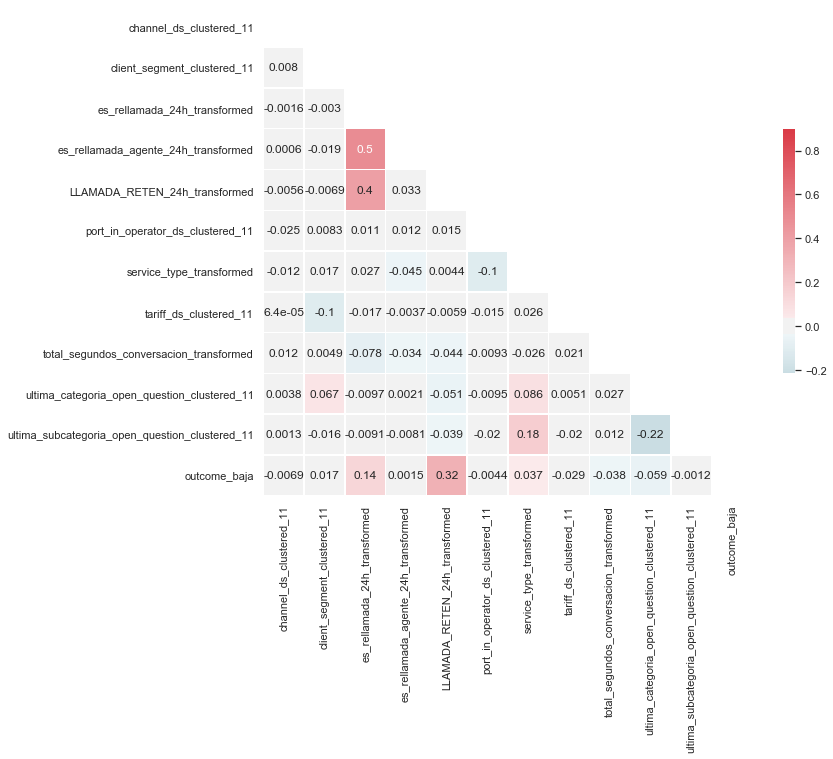

In [666]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
d = main[final_features]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [667]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X, X_test = X[train_index], X[test_index]
    y, y_test = y[train_index], y[test_index]

TRAIN: [21977 36290 25516 ... 15648 40333 35819] TEST: [35112 37248 12019 ... 35252 36855 15460]


### > GradientBoostingClassifier

In [668]:
bst = GradientBoostingClassifier(
    loss='deviance',
    learning_rate=0.008,
    n_estimators=423,
    criterion='friedman_mse',
    min_samples_split=60,
    min_samples_leaf=20,
    max_depth=9,
    max_leaf_nodes=21,
    n_iter_no_change=20,
    tol=0.0001)
bst.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.008, loss='deviance', max_depth=9,
                           max_features=None, max_leaf_nodes=21,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=20, min_samples_split=60,
                           min_weight_fraction_leaf=0.0, n_estimators=423,
                           n_iter_no_change=20, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### > XGBoost

In [669]:
# bst = xgb.XGBClassifier(
#             gamma=0.01,
#             importance_type='gain',
#             learning_rate=0.006,
#             max_depth=5,
#             n_estimators=400,
#             objective='binary:logistic',
#             random_state=17,
#             num_parallel_tree=3)
# bst.fit(X,y)

In [670]:
y_pred_train = bst.predict_proba(X)[:,1]
y_pred_test = bst.predict_proba(X_test)[:,1]

### Importances

In [671]:
fnames = [(e,f) for e,f in zip(final_features, bst.feature_importances_)]
importances = pd.DataFrame(fnames, columns= ["feature","importance"])
importances.sort_values("importance",ascending=False)

,feature,importance
7,tariff_ds_clustered_11,0.180892
9,ultima_categoria_open_question_clustered_11,0.173238
4,LLAMADA_RETEN_24h_transformed,0.155442
6,service_type_transformed,0.123981
10,ultima_subcategoria_open_question_clustered_11,0.106662
5,port_in_operator_ds_clustered_11,0.079656
11,outcome_baja,0.055720
0,channel_ds_clustered_11,0.045119
1,client_segment_clustered_11,0.029810
8,total_segundos_conversacion_transformed,0.026871


### Train CM

finding best threshold..


D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


best threshold: 0.13
f1-score at this threshold: 0.283545197740113


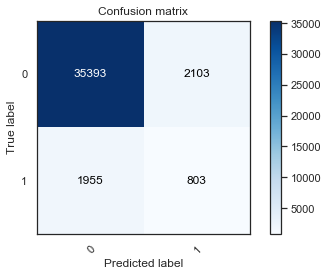

In [672]:
y_pred_train_labels = pred_labels(y_pred_train,y_true = y, jumps = 100)
np.set_printoptions(precision=2)

plot_confusion_matrix(y, y_pred_train_labels, classes=[0,1],
                      title='Confusion matrix')
plt.show()

In [673]:
cm = confusion_matrix(y, y_pred_train_labels)
accuracy = (cm[1,1] + cm[0,0]) / cm.sum() # Overall, how often is the classifier correct?
precision = cm[1,1] / (cm[0,1] + cm[1,1]) # When it predicts yes, how often is it correct? 
sensitivity = cm[1,1] / (cm[1,0] + cm[1,1]) # When it's actually yes, how often does it predict yes?
f1 = f1_score(y,y_pred_train_labels)
print('''==TRAIN===
accuracy: {},
precision: {},
sensitivity: {}
f1-score: {}'''.format(round(accuracy,2),round(precision,2),round(sensitivity,2),round(f1,2)))

==TRAIN===
accuracy: 0.9,
precision: 0.28,
sensitivity: 0.29
f1-score: 0.28


### Test CM

finding best threshold..
best threshold: 0.12
f1-score at this threshold: 0.25569620253164554


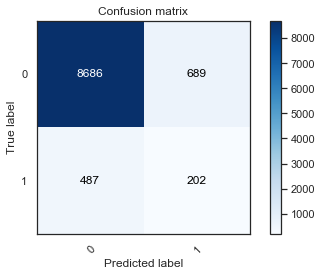

In [674]:
y_pred_test_labels = pred_labels(y_pred_test,y_true = y_test, jumps = 100)
np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred_test_labels, classes=[0,1],
                      title='Confusion matrix')
plt.show()

In [675]:
cm_test = confusion_matrix(y_test, y_pred_test_labels)
accuracy_test = (cm[1,1] + cm[0,0]) / cm.sum() # Overall, how often is the classifier correct?
precision_test = cm[1,1] / (cm[0,1] + cm[1,1]) # When it predicts yes, how often is it correct? 
sensitivity_test = cm[1,1] / (cm[1,0] + cm[1,1]) # When it's actually yes, how often does it predict yes?
f1_test = f1_score(y_test,y_pred_test_labels)
print('''===TEST===
accuracy: {},
precision: {},
sensitivity: {}
f1-score: {}'''.format(round(accuracy_test,2),round(precision_test,2),round(sensitivity_test,2),round(f1_test,2)))

===TEST===
accuracy: 0.9,
precision: 0.28,
sensitivity: 0.29
f1-score: 0.26


# Predict February Data

In [676]:
main_feb = pd.read_pickle('./data/model_data_feb.pkl')

In [677]:
def get_cluster_map(model_data, column, suffix):
    column_w_suffix = column + suffix
    df = model_data[[column,column_w_suffix]].groupby(column).mean()
    return dict(zip(df.index,df[column_w_suffix]))

def apply_cluster(main,column,suffix,cluster_map):
    def find_cluster(x,cluster_map):
        try: return cluster_map[x]
        except:
            try: return cluster_map["Missing"]
            except: return -99
    main[column+suffix] = main[column].apply(find_cluster,args=(cluster_map,))
    return main

### Apply Clusters

In [678]:
for col in final_features:
    if "clustered" in col:
        column = col[:(col.find("clustered")-1)]
        suffix = col[(-1+col.find("clustered")):]
    elif "transformed" in col:
        column = col[:(col.find("transformed")-1)]
        suffix = col[(-1+col.find("transformed")):]
    print(column)
    print(column+suffix)
    cluster_map = get_cluster_map(main,column,suffix)
    main_feb = apply_cluster(main_feb,column,suffix,cluster_map)

channel_ds
channel_ds_clustered_11
client_segment
client_segment_clustered_11
es_rellamada_24h
es_rellamada_24h_transformed
es_rellamada_agente_24h
es_rellamada_agente_24h_transformed
LLAMADA_RETEN_24h
LLAMADA_RETEN_24h_transformed
port_in_operator_ds
port_in_operator_ds_clustered_11
service_type
service_type_transformed
tariff_ds
tariff_ds_clustered_11
total_segundos_conversacion
total_segundos_conversacion_transformed
ultima_categoria_open_question
ultima_categoria_open_question_clustered_11
ultima_subcategoria_open_question
ultima_subcategoria_open_question_clustered_11
ultima_subcategoria_open_question
ultima_subcategoria_open_question_clustered_11


In [679]:
# for col in final_features:
#     print("="*5,end=" ")
#     print(col,end=" ")
#     if "final" not in locals():
#         final = main_feb.groupby(col).TARGET.aggregate(['count','sum','mean'])
#         final["feature"] = col
#     else:
#         tmp = main_feb.groupby(col).TARGET.aggregate(['count','sum','mean'])
#         tmp["feature"] = col
#         final = pd.concat([final,tmp])

In [680]:
# for col in final_features:
#     print("="*5,end=" ")
#     print(col,end=" ")
#     print("="*5)
#     print(main_feb[col].value_counts(dropna=False))

### Predict

In [681]:
X_feb = np.array(main_feb[final_features])
y_feb = np.array(main_feb['TARGET'])

In [682]:
y_pred_feb = bst.predict_proba(X_feb)[:,1]

### Draw Confusion Matrix

finding best threshold..


D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


best threshold: 0.12
f1-score at this threshold: 0.2265774378585086


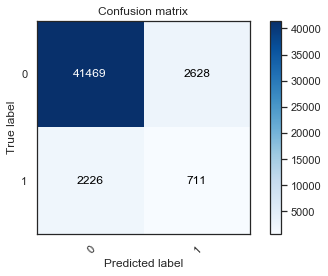

In [683]:
y_pred_feb_labels = pred_labels(y_pred_feb,y_true = y_feb, jumps = 100)
np.set_printoptions(precision=2)

plot_confusion_matrix(y_feb, y_pred_feb_labels, classes=[0,1],
                      title='Confusion matrix')
plt.show()

In [684]:
cm_feb = confusion_matrix(y_feb, y_pred_feb_labels)
accuracy_feb = (cm[1,1] + cm[0,0]) / cm.sum() # Overall, how often is the classifier correct?
precision_feb = cm[1,1] / (cm[0,1] + cm[1,1]) # When it predicts yes, how often is it correct? 
sensitivity_feb = cm[1,1] / (cm[1,0] + cm[1,1]) # When it's actually yes, how often does it predict yes?
f1_feb = f1_score(y_feb,y_pred_feb_labels)
print('''===TEST===
accuracy: {},
precision: {},
sensitivity: {}
f1-score: {}'''.format(round(accuracy_feb,2),round(precision_feb,2),round(sensitivity_feb,2),round(f1_feb,2)))

===TEST===
accuracy: 0.9,
precision: 0.28,
sensitivity: 0.29
f1-score: 0.23


### ROC Curves

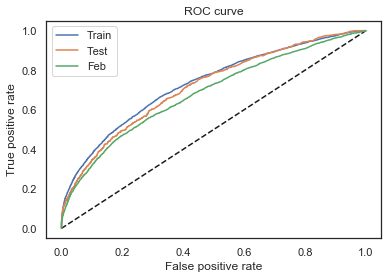

In [685]:
bst_fpr_train, bst_tpr_train, _bst_train = roc_curve(y, y_pred_train)
bst_auc_train = roc_auc_score(y,y_pred_train)

bst_fpr_test, bst_tpr_test, _bst_test = roc_curve(y_test, y_pred_test)
bst_auc_test = roc_auc_score(y_test,y_pred_test)

bst_fpr_feb, bst_tpr_feb, _bst_feb = roc_curve(y_feb, y_pred_feb)
bst_auc_feb = roc_auc_score(y_feb,y_pred_feb)

# tpr = tp / (tp + fn)
# fpr = fp / (fp + tn)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(bst_fpr_train, bst_tpr_train, label='Train')
plt.plot(bst_fpr_test, bst_tpr_test, label='Test')
plt.plot(bst_fpr_feb, bst_tpr_feb, label='Feb')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [686]:
print("AUC in Gradient Boosting - Train: "+str(bst_auc_train))
print("AUC in Gradient Boosting - Test : "+str(bst_auc_test))
print("AUC in Gradient Boosting - Feb  : "+str(bst_auc_feb))

AUC in Gradient Boosting - Train: 0.7300648303138315
AUC in Gradient Boosting - Test : 0.7159503047895501
AUC in Gradient Boosting - Feb  : 0.6830644902068396


In [687]:
main['outcome_baja'].value_counts()

0    48321
1     1997
Name: outcome_baja, dtype: int64

In [688]:
main.groupby('LLAMADA_RETEN_24h_transformed').TARGET.aggregate(['mean','count','sum'])

,mean,count,sum
LLAMADA_RETEN_24h_transformed,,,
0,0.063137,48941,3090
1,0.259259,1377,357


In [689]:
main.groupby('llamada_reten_7D_transformed').TARGET.aggregate(['mean','count','sum'])

,mean,count,sum
llamada_reten_7D_transformed,,,
0,0.060402,48260,2915
1,0.258503,2058,532


In [690]:
main.groupby('outcome_baja').TARGET.aggregate(['mean','count','sum'])

,mean,count,sum
outcome_baja,,,
0,0.062913,48321,3040
1,0.203806,1997,407


In [694]:
[e for e in main.columns if e.find('llamada_reten_30D_transformed')!=-1]

[]